# Transport Budget

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds = xr.open_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/GOPAF/datasets/vels.zarr'))

In [3]:
ds

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, longitude: 336, time: 305)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01
Data variables:
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(10, 50, 109, 336), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(10, 50, 109, 336), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.11
    contact:           https://marine.copernicus.eu/contact
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    institution:       Mercator Ocean International
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    references:        http://marine.copernicus.eu
    source:            MOI GLO12
    subset:datasetId:  cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_202211
    subset:date:       2024-02-12T18:38:44.384Z
    subset:productId:  GLOBAL_ANALYSISFORECAST_PHY_001_024
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    title:             daily mean fields from Global Ocean Physics Analysis a...

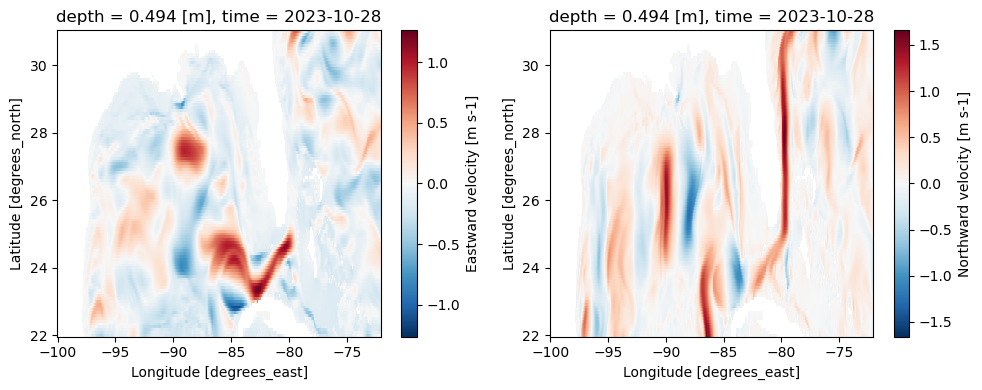

In [4]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
ds.uo[300,0].plot(ax=ax0)
ds.vo[300,0].plot(ax=ax1)
plt.tight_layout();

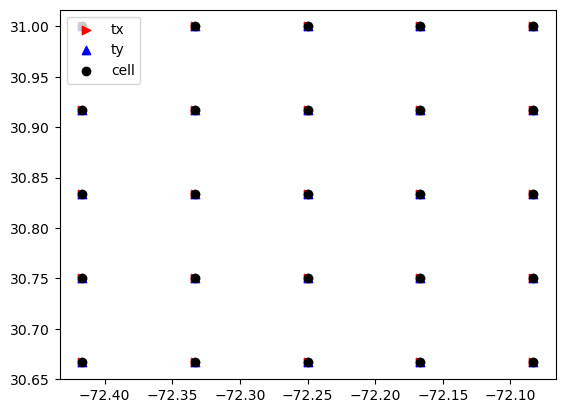

In [31]:
from matplotlib import pyplot as plt

tx_y, tx_x = xr.broadcast(*(ds0[dim] for dim in ds0.uo.sum('depth').dims))
ty_y, ty_x = xr.broadcast(*(ds0[dim] for dim in ds0.vo.sum('depth').dims))
cell_y, cell_x = xr.broadcast(ds0.latitude, ds0.longitude)

plt.scatter(tx_x[-5:, -5:], tx_y[-5:, -5:], color='r', label="tx", marker=">")
plt.scatter(ty_x[-5:, -5:], ty_y[-5:, -5:], color='b', label="ty", marker="^")
plt.scatter(cell_x[-5:, -5:], cell_y[-5:, -5:], color='k', label="cell", marker="o")
plt.legend(loc="upper left")

In [5]:
ds_pt_full = generate_grid_ds(ds, {'X':'longitude', 'Y':'latitude'})
grid = xgcm.Grid(ds_pt_full, periodic=['X', 'Y'])#, boundary="fill", fill_value=0.)

In [6]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center
Y Axis (periodic, boundary=None):
  * center   latitude --> left
  * left     latitude_left --> center
Z Axis (not periodic, boundary=None):
  * center   depth
T Axis (not periodic, boundary=None):
  * center   time

In [7]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
   
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'].astype('f4'), 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}'].astype('f4')))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'].astype('f4'), 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left'].astype('f4')))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [8]:
cell_elements = deg_2_m(grid, ds_pt_full, 'latitude', 'longitude')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


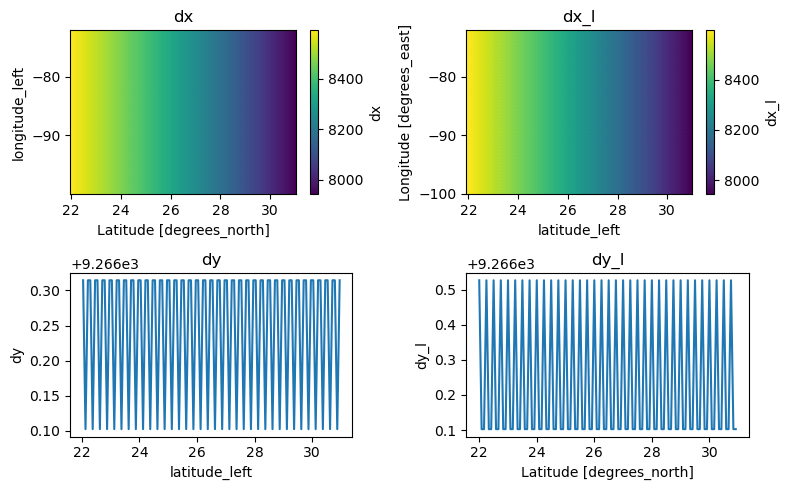

In [9]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

In [42]:
dx_interp = grid.interp(cell_elements.dx_l, 'Y')
dz = ds.depth.diff(dim='depth', label='upper')

u_vol_weighted_unsliced = ds.uo.isel(depth=slice(1,None)) * cell_elements.dy_l * dz
u_vol_weighted = u_vol_weighted_unsliced.isel(latitude=slice(None, -1)) #m^3/s
v_vol_weighted = ds.vo.isel(depth=slice(1,None), latitude=slice(None, -1)) * dx_interp[:, :-1] * dz #m^3/s

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [41]:
u_vol_weighted.coords

Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.75 30.83 30.92
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01

In [36]:
v_vol_weighted.coords

Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.75 30.83 30.92
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01

In [43]:
u_left = u_vol_weighted.isel(longitude=0)
u_right = u_vol_weighted.isel(longitude=-1)
v_bottom = v_vol_weighted.isel(latitude=0)
v_top = v_vol_weighted.isel(latitude=-1)

In [52]:
u_left.coords

Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.75 30.83 30.92
    longitude  float32 -100.0
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01

In [51]:
u_right.coords

Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.75 30.83 30.92
    longitude  float32 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01

In [49]:
v_bottom.coords

Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03
    latitude   float32 22.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01

In [50]:
v_top.coords

Coordinates:
  * depth      (depth) float32 1.541 2.646 3.819 ... 5.275e+03 5.728e+03
    latitude   float32 30.92
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01

In [45]:
residual = (u_left.sum(['depth', 'latitude'])
            - u_right.sum(['depth', 'latitude'])
            + v_bottom.sum(['depth', 'longitude'])
            - v_top.sum(['depth', 'longitude']))

In [55]:
residual.mean('time').values/1e6

-55.360516

In [54]:
residual.isel(time=100).values/1e6

-2615.904